In [5]:
# !pip install numpy


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
!which python

/home/murali/anaconda3/envs/myenv/bin/python


In [65]:
print(cv2.__version__)

4.10.0


In [2]:
# !conda info --envs

# conda environments:
#
base                  *  /Users/sreekanthgopi/miniconda3
                         /Users/sreekanthgopi/opt/anaconda3/envs/AutoGPT
                         /Users/sreekanthgopi/opt/anaconda3/envs/AutoGPT2
                         /Users/sreekanthgopi/opt/anaconda3/envs/FaceNet
                         /Users/sreekanthgopi/opt/anaconda3/envs/MMMMusic
                         /Users/sreekanthgopi/opt/anaconda3/envs/TopicGeneration
                         /Users/sreekanthgopi/opt/anaconda3/envs/audiocraft
                         /Users/sreekanthgopi/opt/anaconda3/envs/magenta
                         /Users/sreekanthgopi/opt/anaconda3/envs/muse_env



In [6]:
# !pip show numpy

In [7]:
# !pip install opencv-python


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [14]:
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [64]:
# pip install mediapipe

Read 1000 frames.
1000 frames saved to file.


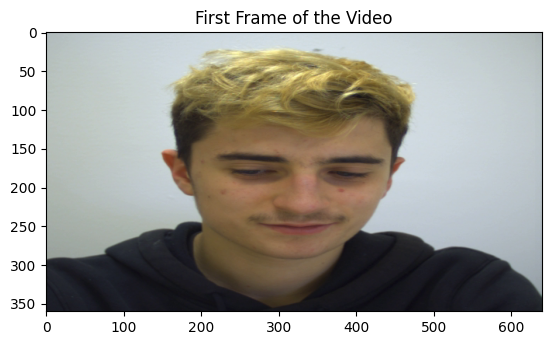

In [1]:
import cv2
import pickle
import os
import matplotlib.pyplot as plt

def read_video_frames(video_file, max_frames=1000):
    cap = cv2.VideoCapture(video_file)
    frames = []
    count = 0
    while count < max_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Stop if no frame is retrieved
        frames.append(frame)
        count += 1
    cap.release()
    print(f"Read {count} frames.")
    return frames

def display_first_frame(frames):
    if frames is not None and len(frames) > 0:
        frame_rgb = cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title("First Frame of the Video")
        plt.show()
    else:
        print("No frame to display.")

def load_or_read_video_frames(video_path, frames_filename='saved_framess2t1.pkl', max_frames=1000):
    # Check if frames are already saved to a file
    if os.path.isfile(frames_filename):
        # If frames are saved, load them from the file
        with open(frames_filename, 'rb') as file:
            frames = pickle.load(file)
        print("Frames loaded from file.")
    else:
        # If frames are not saved, read and store video frames
        frames = read_video_frames(video_path, max_frames)
        # Save the frames to a file for future use
        with open(frames_filename, 'wb') as file:
            pickle.dump(frames, file)
        print(f"{len(frames)} frames saved to file.")
    return frames

video_path = 'vid_s1_T1.mp4'
frames_filename = 'saved_framess2t1_T1.pkl'

frames = load_or_read_video_frames(video_path, frames_filename, max_frames=1000)
display_first_frame(frames)


In [2]:
len(frames)

1000

### Processed Frame with Face Mesh and Highlighted ROIs

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1718118186.427429  166711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718118186.435757  166712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/murali/anaconda3/envs/myenv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


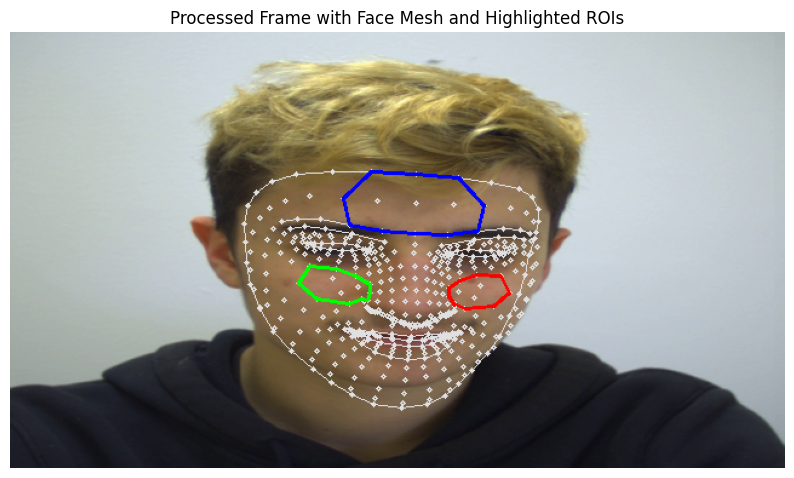

In [3]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe FaceMesh
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

# Specify the drawing specifications for visualization
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
def process_frames_and_extract_roi_values(frames):
    processed_frames = []
    roi_signals = {'forehead': [], 'left_cheek': [], 'right_cheek': []}

    with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        for frame in frames:
            frame_copy = frame.copy()
            image_rgb = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)
            results_mesh = face_mesh.process(image_rgb)

            if results_mesh.multi_face_landmarks:
                for face_landmarks in results_mesh.multi_face_landmarks:
                    # Drawing the facial landmarks for visualization
                    mp_drawing.draw_landmarks(frame_copy, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, landmark_drawing_spec=drawing_spec, connection_drawing_spec=drawing_spec)

                    # For each ROI, calculate, store the mean pixel values, and draw the ROI
                    for name, indices in [('forehead', [107, 66, 69, 109, 10, 338, 299, 296, 336, 9]), 
                                          ('left_cheek', [118, 119, 100, 126, 209, 49, 129, 203, 205, 50]), 
                                          ('right_cheek', [347, 348, 329, 355, 429, 279, 358, 423, 425, 280])]:
                        # Extracting ROI pixels
                        roi_pixels = np.array([frame[int(face_landmarks.landmark[idx].y * frame.shape[0]), int(face_landmarks.landmark[idx].x * frame.shape[1])] for idx in indices])
                        mean_pixel_value = np.mean(roi_pixels, axis=0)
                        roi_signals[name].append(mean_pixel_value)

                        # Drawing ROI
                        points = np.array([[int(face_landmarks.landmark[idx].x * frame_copy.shape[1]), int(face_landmarks.landmark[idx].y * frame_copy.shape[0])] for idx in indices])
                        cv2.polylines(frame_copy, [np.array(points)], True, (255, 0, 0) if name == 'forehead' else (0, 255, 0) if name == 'left_cheek' else (0, 0, 255), 2)

            processed_frames.append(frame_copy)

    return processed_frames, roi_signals


processed_frames, roi_signals = process_frames_and_extract_roi_values(frames)

# Display one of the processed frames with ROIs
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(processed_frames[0], cv2.COLOR_BGR2RGB))
plt.title('Processed Frame with Face Mesh and Highlighted ROIs')
plt.axis('off')
plt.show()


In [4]:
print(f"Total frames read: {len(frames)}")

Total frames read: 1000


In [5]:
import pandas as pd

# Create DataFrame from roi_signals
roi_df = pd.DataFrame.from_dict(roi_signals)

# Save DataFrame to CSV
roi_df.to_csv('roi_signals_T1.csv', index=False)


In [6]:
# (processed_frames[0])

In [7]:
# import numpy as np
# import pandas as pd

# # Assuming processed_frames is a list of arrays
# # Flatten each array and concatenate them along the appropriate axis
# flattened_data = np.concatenate([arr.flatten().reshape(1, -1) for arr in processed_frames])

# # Convert the flattened data to a DataFrame
# processed_frames_df = pd.DataFrame(flattened_data)

# # Save DataFrame to CSV
# processed_frames_df.to_csv('processed_frames.csv', index=False)


In [8]:
len(roi_signals.keys())

3

In [9]:
print(f"Number of ROIs: {len(roi_signals.keys())}")
for roi, values in roi_signals.items():
    print(f"{roi}: {values[:5]}")  # Print first 5 values for each ROI


Number of ROIs: 3
forehead: [array([ 64.5,  93.2, 116.2]), array([ 66.9,  96.3, 119.6]), array([ 66.7,  96.6, 119.9]), array([ 61.8,  89.4, 110.2]), array([ 67. ,  97.5, 121.5])]
left_cheek: [array([ 76.2, 108.1, 148. ]), array([ 77.4, 110.2, 150.3]), array([ 77.9, 110.4, 149.7]), array([ 78.8, 112.5, 152.9]), array([ 78.2, 111.9, 152.3])]
right_cheek: [array([ 92.1, 118.6, 158. ]), array([ 91.5, 118. , 157.1]), array([ 90.7, 117.5, 156.2]), array([ 91.2, 119.2, 157.4]), array([ 91.9, 118.9, 158.2])]


In [10]:
print(f"Number of ROIs: {len(roi_signals.keys())}")
for roi, values in roi_signals.items():
    print(f"{roi}: {values[:5]}")  # Print first 5 values for each ROI
    print(f"Type of values in {roi}: {type(values[0])}")  # Check type of values for each ROI
    print(f"Type of values in {roi}: {values[0].dtype}")  # Check datatype of values for each ROI

Number of ROIs: 3
forehead: [array([ 64.5,  93.2, 116.2]), array([ 66.9,  96.3, 119.6]), array([ 66.7,  96.6, 119.9]), array([ 61.8,  89.4, 110.2]), array([ 67. ,  97.5, 121.5])]
Type of values in forehead: <class 'numpy.ndarray'>
Type of values in forehead: float64
left_cheek: [array([ 76.2, 108.1, 148. ]), array([ 77.4, 110.2, 150.3]), array([ 77.9, 110.4, 149.7]), array([ 78.8, 112.5, 152.9]), array([ 78.2, 111.9, 152.3])]
Type of values in left_cheek: <class 'numpy.ndarray'>
Type of values in left_cheek: float64
right_cheek: [array([ 92.1, 118.6, 158. ]), array([ 91.5, 118. , 157.1]), array([ 90.7, 117.5, 156.2]), array([ 91.2, 119.2, 157.4]), array([ 91.9, 118.9, 158.2])]
Type of values in right_cheek: <class 'numpy.ndarray'>
Type of values in right_cheek: float64


In [11]:
print(f"Type of values in {roi}: {values[0].dtype}")  # Check datatype of values for each ROI

Type of values in right_cheek: float64


In [12]:
if len(frames) > 0:
    print(f"First frame shape: {frames[0].shape}, dtype: {frames[0].dtype}")
else:
    print("No frames to display.")

First frame shape: (360, 640, 3), dtype: uint8


In [16]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    if len(data) < 3 * order:
        print("Data too short for this order, considering padding or lowering order.")
        order = min(order, len(data) // 3)
    b, a = butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

fs = 35  
lowcut = 0.65
highcut = 4.0


# Convert lists of pixel values into numpy arrays
for roi, signals_list in roi_signals.items():
    roi_signals[roi] = np.array(signals_list)

filtered_signals = {}

for roi, signals in roi_signals.items():
    if signals.shape[0] > 1:
        filtered_signal = np.zeros_like(signals)
        for i in range(signals.shape[1]):  # Filtering channel-wise
            filtered_signal[:, i] = butter_bandpass_filter(signals[:, i], lowcut, highcut, fs, order=6)
        filtered_signals[roi] = filtered_signal
    else:
        print(f"Not enough data for filtering {roi}, skipping.")
        filtered_signals[roi] = signals

# Print the filtered_signals dictionary
print("Filtered Signals:")
for roi, signals in filtered_signals.items():
    print(f"ROI: {roi}, Filtered Signals Shape: {signals.shape}")

Filtered Signals:
ROI: forehead, Filtered Signals Shape: (974, 3)
ROI: left_cheek, Filtered Signals Shape: (974, 3)
ROI: right_cheek, Filtered Signals Shape: (974, 3)


W0000 00:00:1718033613.958881  119999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718033613.976372  119999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


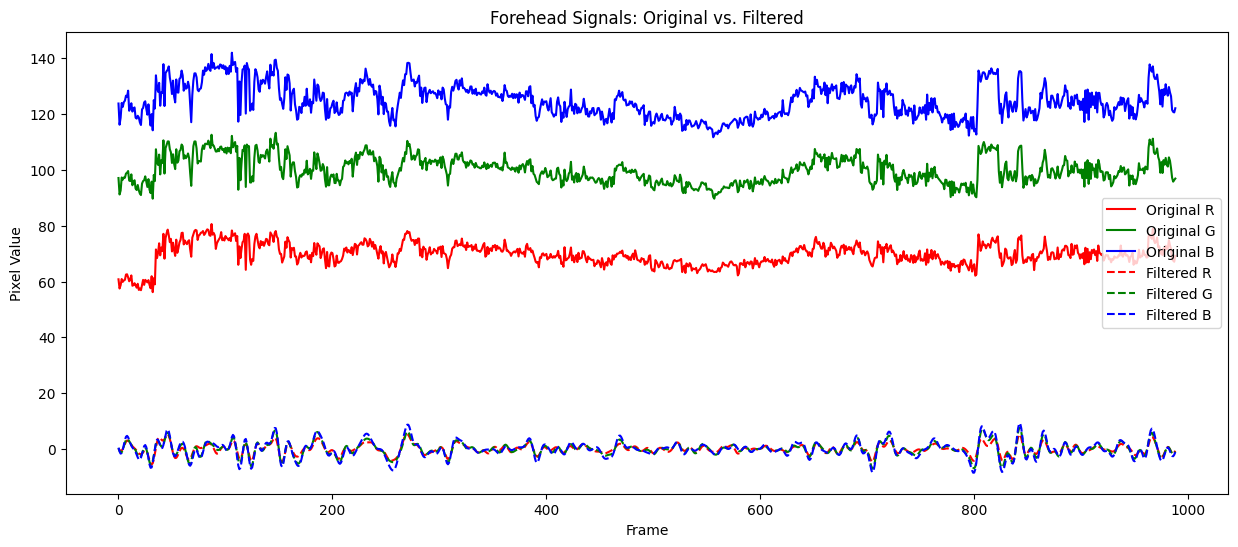

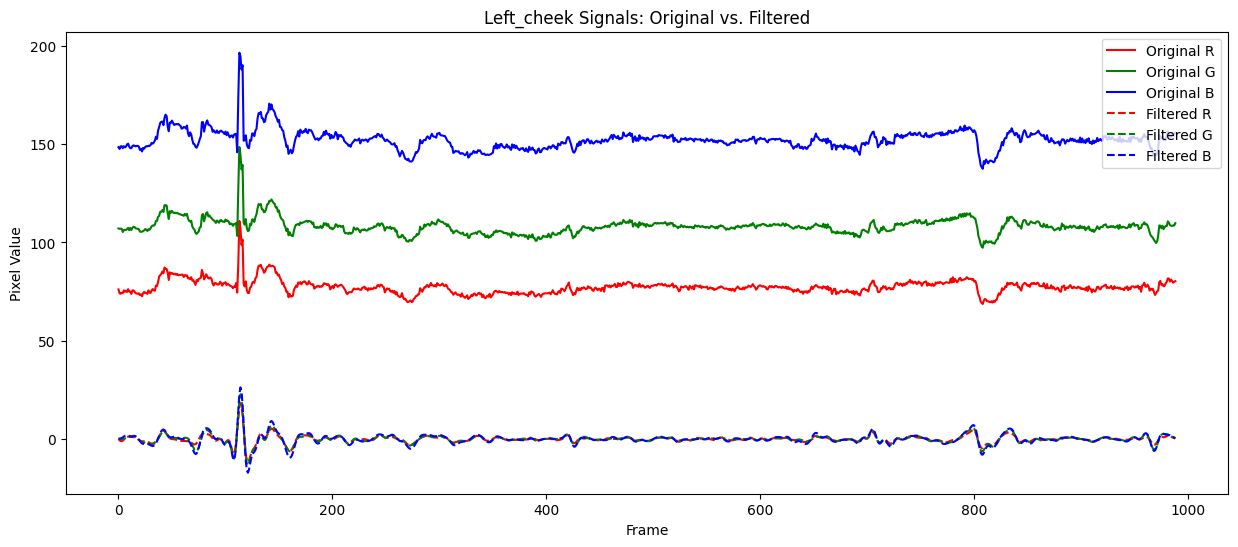

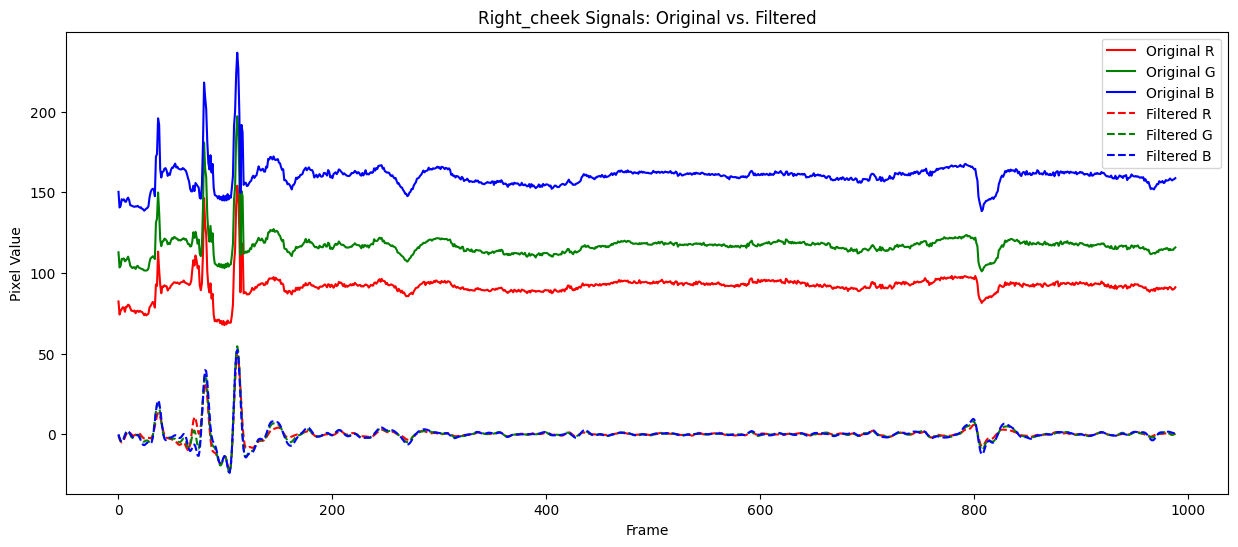

In [15]:
import matplotlib.pyplot as plt

def plot_signals(original_signals, filtered_signals, title):
    plt.figure(figsize=(15, 6))
    
    # Plotting the original signals
    plt.plot(original_signals[:, 0], 'r', label='Original R')
    plt.plot(original_signals[:, 1], 'g', label='Original G')
    plt.plot(original_signals[:, 2], 'b', label='Original B')
    
    # Plotting the filtered signals
    plt.plot(filtered_signals[:, 0], 'r--', label='Filtered R')
    plt.plot(filtered_signals[:, 1], 'g--', label='Filtered G')
    plt.plot(filtered_signals[:, 2], 'b--', label='Filtered B')
    
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel('Pixel Value')
    plt.legend()
    plt.show()

processed_frames, roi_signals = process_frames_and_extract_roi_values(frames)

# Convert lists of pixel values into numpy arrays
for roi, signals_list in roi_signals.items():
    roi_signals[roi] = np.array(signals_list)

# Plot the signals before and after filtering for each ROI
for roi, original_signals in roi_signals.items():
    filtered_signals_roi = filtered_signals.get(roi)
    if filtered_signals_roi is not None:
        plot_signals(original_signals, filtered_signals_roi, f'{roi.capitalize()} Signals: Original vs. Filtered')
    else:
        print(f"No filtered signals available for {roi}. Skipping plotting.")


In [17]:
# Example diagnostic print for signals
for roi, signals in filtered_signals.items():
    print(f"{roi}: G Sample: {signals[:, 1][:5]}, R Sample: {signals[:, 0][:5]}, B Sample: {signals[:, 2][:5]}")

forehead: G Sample: [-0.23953144 -0.04157624  0.311932    0.89246991  1.64241781], R Sample: [-0.20867787 -0.10830645  0.13662329  0.5911024   1.20107973], B Sample: [-0.31751566 -0.2757942   0.00831618  0.64991022  1.57055527]
left_cheek: G Sample: [0.05773831 1.28933176 2.28599628 2.88582273 3.04492227], R Sample: [0.05352828 0.73850478 1.29386664 1.62826108 1.71232109], B Sample: [0.11271019 1.34969056 2.32804986 2.87071711 2.93262959]
right_cheek: G Sample: [ 0.02724077 -0.10935365 -0.19397532 -0.19056193 -0.09059262], R Sample: [ 0.0256447  -0.27402137 -0.53703019 -0.73377461 -0.8474228 ], B Sample: [ 0.05644917 -0.3703219  -0.70573449 -0.8802267  -0.86378459]


In [18]:
import random

# Print random values from filtered_signals
for roi, signals in filtered_signals.items():
    if signals.shape[0] > 1:
        random_index = random.randint(0, signals.shape[0] - 1)
        random_value = signals[random_index]
        print(f"ROI: {roi}, Random Value at Index {random_index}: {random_value}")
    else:
        print(f"No data for {roi}, skipping.")


ROI: forehead, Random Value at Index 496: [1.06752547 1.1396892  1.85625216]
ROI: left_cheek, Random Value at Index 710: [-0.54098573 -0.13633162 -0.61003487]
ROI: right_cheek, Random Value at Index 684: [-0.29713691 -0.40176343 -0.12282207]


In [19]:
type(filtered_signals)

dict

In [20]:
import pandas as pd

# Flatten the nested lists in filtered_signals dictionary
flattened_signals = {roi + '_' + channel: [signal[i] for signal in signals for i in range(len(signal))] for roi, signals in filtered_signals.items() for channel in ['R', 'G', 'B']}

# Create DataFrame from flattened dictionary
filtered_df = pd.DataFrame.from_dict(flattened_signals)

# Save DataFrame to CSV file
filtered_csv_path = 'filtered_signals.csv'
filtered_df.to_csv(filtered_csv_path, index=False)

print(f"Filtered signals saved to {filtered_csv_path}")


Filtered signals saved to filtered_signals.csv


In [21]:
def plot_signals2(original_signals, filtered_signals, title):
    plt.figure(figsize=(15, 6))
    
    # Plotting the original signals
    plt.plot(original_signals[:, 0], 'r', label='Filtered R')
    
    # Plotting the filtered signals with an offset in the y-axis
    plt.plot(filtered_signals[:, 0] , 'r--', label='Detrended R (Offset)')
    
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel('Pixel Value')
    plt.legend()
    plt.show()


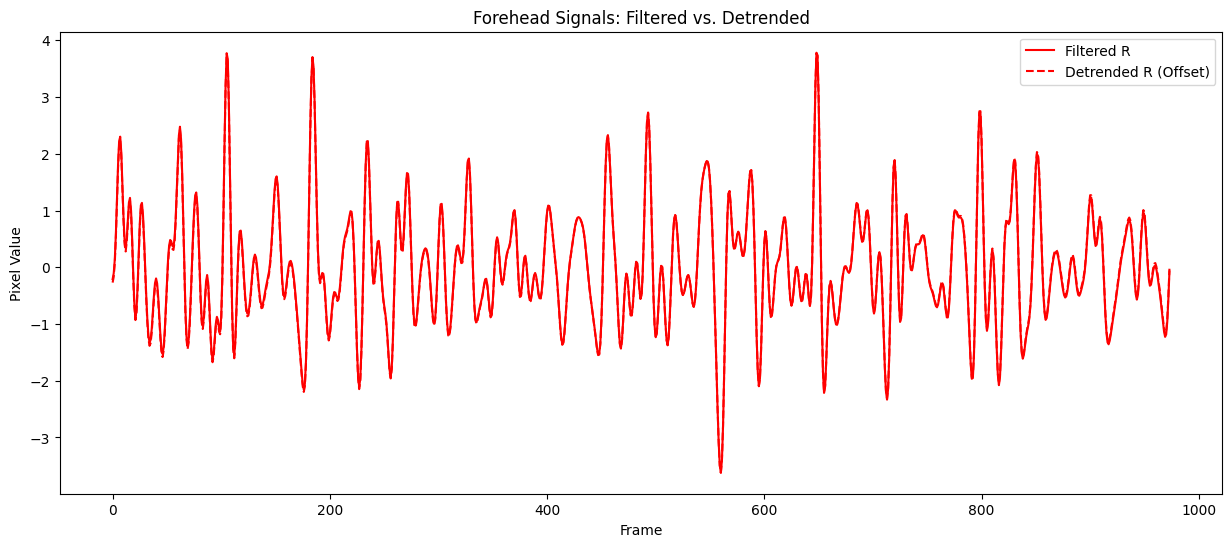

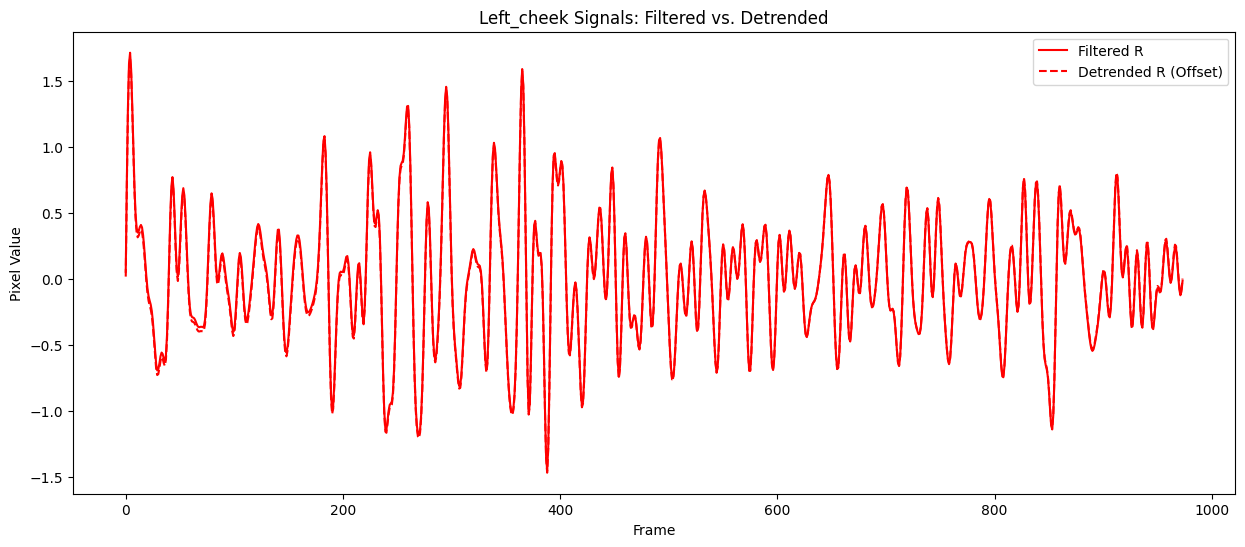

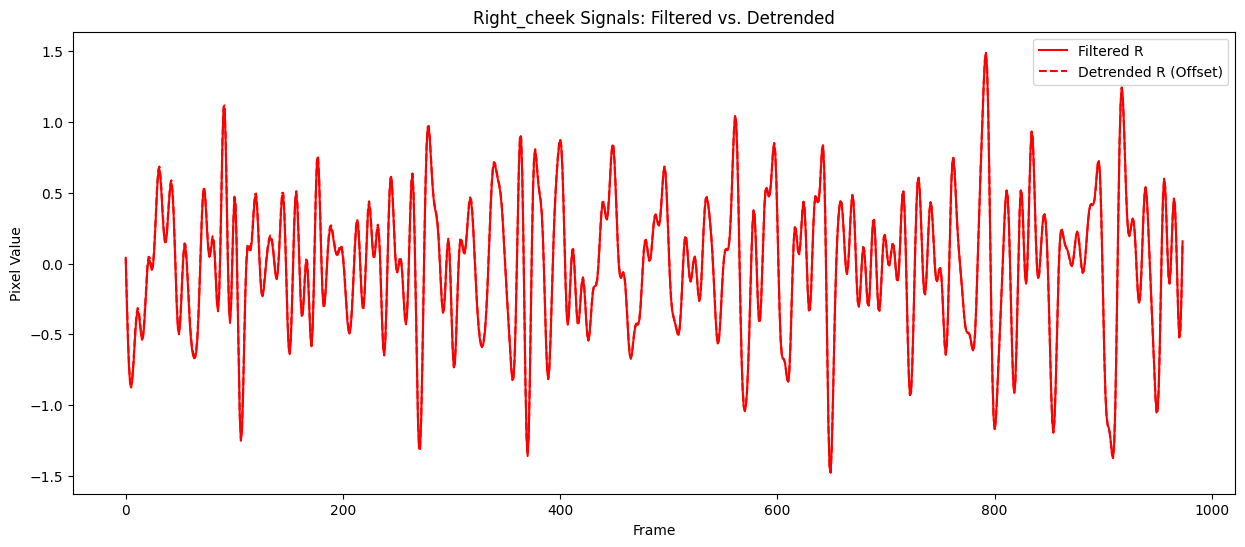

In [22]:
from scipy.signal import detrend

# Function to detrend the signals for each ROI
def detrend_roi_signals(filtered_signals):
    detrended_signals = {}
    for roi, signals in filtered_signals.items():
        detrended_signals[roi] = detrend(signals, axis=0)
    return detrended_signals

# Detrend the filtered signals for each ROI
detrended_signals = detrend_roi_signals(filtered_signals)

# Plot the detrended signals for each ROI
for roi, detrended_signal in detrended_signals.items():
    plot_signals2(filtered_signals[roi], detrended_signal, f'{roi.capitalize()} Signals: Filtered vs. Detrended')


In [23]:
type(detrended_signals)

dict

In [24]:
for roi, signals in detrended_signals.items():
    print(f"{roi}: {signals[:5]}")  # Print first 5 detrended values for each ROI


forehead: [[-0.27023226 -0.31314848 -0.40225626]
 [-0.16974763 -0.11506802 -0.36038095]
 [ 0.07529531  0.23856548 -0.07611672]
 [ 0.52988763  0.81922866  0.56563116]
 [ 1.13997818  1.56930182  1.48643006]]
left_cheek: [[ 0.01695994 -0.01630086  0.04669636]
 [ 0.70199174  1.21541035  1.28378119]
 [ 1.2574089   2.21219263  2.26224496]
 [ 1.59185864  2.81213685  2.80501669]
 [ 1.67597394  2.97135416  2.86703363]]
right_cheek: [[ 0.04828852  0.02940065  0.07474239]
 [-0.25140883 -0.1072002  -0.35206427]
 [-0.51444894 -0.1918283  -0.68751247]
 [-0.71122466 -0.18842134 -0.86204028]
 [-0.82490414 -0.08845846 -0.84563376]]


### Detrend the signals for each ROI

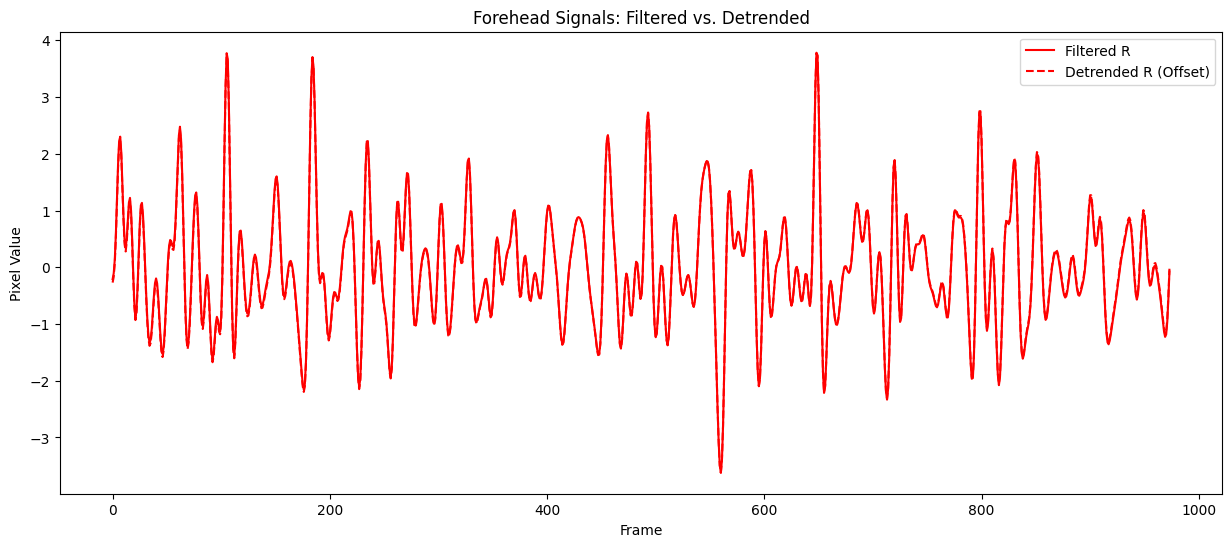

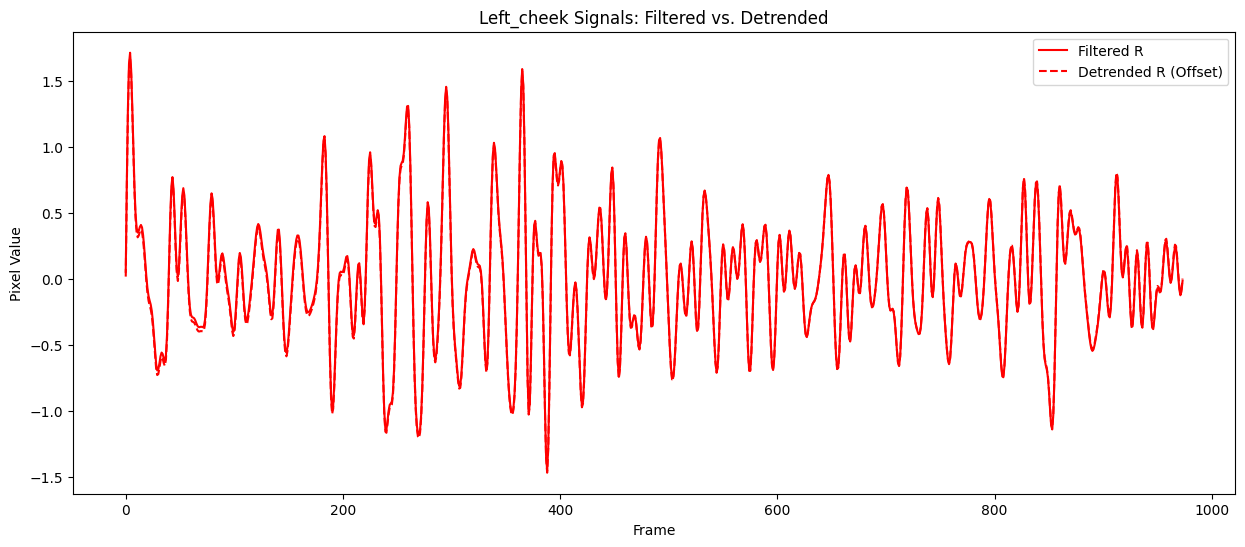

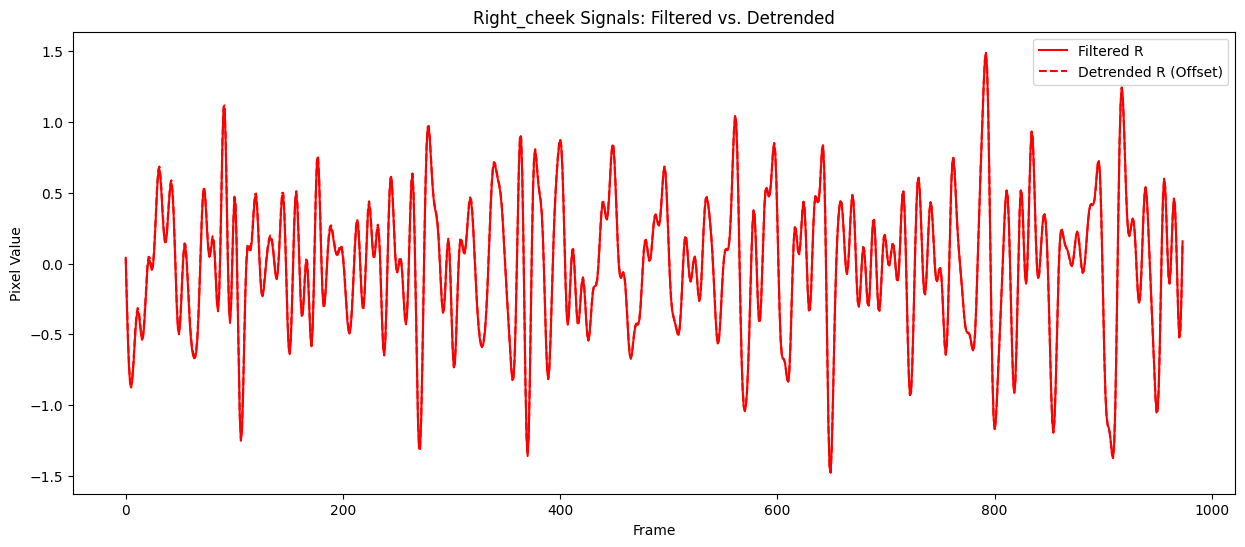

In [25]:
from scipy.signal import detrend

# Function to detrend the signals for each ROI
def detrend_roi_signals(filtered_signals):
    detrended_signals = {}
    for roi, signals in filtered_signals.items():
        detrended_signals[roi] = detrend(signals, axis=0)
    return detrended_signals

# Detrend the filtered signals for each ROI
detrended_signals = detrend_roi_signals(filtered_signals)

# Plot the detrended signals for each ROI
for roi, detrended_signal in detrended_signals.items():
    plot_signals2(filtered_signals[roi], detrended_signal, f'{roi.capitalize()} Signals: Filtered vs. Detrended')


### Processed Frame with Face Mesh and Highlighted ROIs

In [26]:
for roi, signals in filtered_signals.items():
    print(f"{roi}, filtered sample: {signals[:5]}")  # Print first 5 filtered values for each ROI

forehead, filtered sample: [[-0.20867787 -0.23953144 -0.31751566]
 [-0.10830645 -0.04157624 -0.2757942 ]
 [ 0.13662329  0.311932    0.00831618]
 [ 0.5911024   0.89246991  0.64991022]
 [ 1.20107973  1.64241781  1.57055527]]
left_cheek, filtered sample: [[0.05352828 0.05773831 0.11271019]
 [0.73850478 1.28933176 1.34969056]
 [1.29386664 2.28599628 2.32804986]
 [1.62826108 2.88582273 2.87071711]
 [1.71232109 3.04492227 2.93262959]]
right_cheek, filtered sample: [[ 0.0256447   0.02724077  0.05644917]
 [-0.27402137 -0.10935365 -0.3703219 ]
 [-0.53703019 -0.19397532 -0.70573449]
 [-0.73377461 -0.19056193 -0.8802267 ]
 [-0.8474228  -0.09059262 -0.86378459]]


### Plot original vs. filtered signals for a specific ROI

### GRGB Calculation

In [27]:
flattened_detrend_signals = {roi + '_' + channel: [signal[i] for signal in signals for i in range(len(signal))] for roi, signals in detrended_signals.items() for channel in ['R', 'G', 'B']}

In [28]:
detrended_df = pd.DataFrame.from_dict(flattened_detrend_signals)

In [29]:
# import numpy as np

# def calculate_color_channel_ratios(detrended_df):
#     ratios = {}
#     for column_prefix in ['forehead', 'left_cheek', 'right_cheek']:
#         R = detrended_df[f'{column_prefix}_R'].values
#         G = detrended_df[f'{column_prefix}_G'].values
#         B = detrended_df[f'{column_prefix}_B'].values
#         GR_ratio = G / (R + 1e-6)  # Adding epsilon to avoid division by zero
#         GB_ratio = G / (B + 1e-6)
#         GRGB = GR_ratio + GB_ratio
#         ratios[column_prefix] = GRGB  # Storing the time series GRGB ratio for each ROI
    
#     return ratios

# # Calculate the color channel ratios
# color_channel_ratios = calculate_color_channel_ratios(detrended_df)


In [30]:
type(detrended_signals)

dict

In [31]:
detrended_signals1 = {key: value.tolist() for key, value in detrended_signals.items()}

dfdetrend = pd.DataFrame.from_dict(detrended_signals1)

In [32]:
dfdetrend

,forehead,left_cheek,right_cheek
0,"[-0.27023226270060086, -0.3131484813306046, -0...","[0.016959938032886396, -0.016300863102387993, ...","[0.04828852270144555, 0.029400647937998688, 0...."
1,"[-0.1697476343092557, -0.11506801721607, -0.36...","[0.7019917426309095, 1.2154103545678416, 1.283...","[-0.2514088292062552, -0.10720020105362782, -0..."
2,"[0.07529531264726072, 0.23856548459783167, -0....","[1.2574088981122307, 2.2121926338101416, 2.262...","[-0.5144489418884332, -0.19182830493970568, -0..."
3,"[0.5298876334012825, 0.819228661147756, 0.5656...","[1.5918586381215272, 2.8121368548141263, 2.805...","[-0.7112246555535308, -0.18842134377837852, -0..."
4,"[1.1399781789813217, 1.5693018240330974, 1.486...","[1.6759739409341754, 2.971354160372371, 2.8670...","[-0.8249041370432981, -0.08845845656326358, -0..."
...,...,...,...
969,"[-1.178545668325176, -0.6980071363971883, -1.7...","[0.044816813709088715, -0.0815200201556679, -0...","[-0.3702079941572899, 0.46065267537584625, 0.6..."
970,"[-1.1361316019193402, -0.6850670734181405, -1....","[-0.061124067555157896, -0.08631073025893717, ...","[-0.5221789279341031, 0.46354195988850155, 0.5..."
971,"[-0.913596553287654, -0.5608396221029595, -1.4...","[-0.10725255935951555, -0.06767386168528919, -...","[-0.4725881812362264, 0.4064224444486014, 0.46..."
972,"[-0.5213758606953696, -0.3302932303256578, -0....","[-0.07878692473200097, -0.014480428635950005, ...","[-0.22289137412482887, 0.3031628444065896, 0.3..."


In [33]:
filtered_signals_lists = {key: value.tolist() for key, value in filtered_signals.items()}
df3 = pd.DataFrame(filtered_signals_lists)
df3.head()

,forehead,left_cheek,right_cheek
0,"[-0.2086778660896617, -0.2395314382598645, -0....","[0.05352827737344962, 0.05773831047935856, 0.1...","[0.025644696310414865, 0.027240772526389463, 0..."
1,"[-0.1083064480372285, -0.04157623871051125, -0...","[0.7385047839533855, 1.2893317633191992, 1.349...","[-0.27402136586156667, -0.10935364813260731, -..."
2,"[0.13662328858037603, 0.3119319985382091, 0.00...","[1.2938666414166196, 2.28599627773111, 2.32804...","[-0.5370301888080254, -0.19397532368605544, -0..."
3,"[0.5911023989954859, 0.8924699105229521, 0.649...","[1.6282610834078288, 2.8858227339047056, 2.870...","[-0.733774612737404, -0.19056193419209855, -0...."
4,"[1.2010797342366133, 1.642417808843112, 1.5705...","[1.7123210882023898, 3.0449222746325617, 2.932...","[-0.8474228044914521, -0.09059261864435386, -0..."


In [34]:
import numpy as np

def calculate_green_channel_ratio(filtered_signals):
    ratios = {}
    for column_prefix, signal_array in filtered_signals.items():
        G = signal_array[:, 1]  # Green channel is the second column (index 1)
        ratios[column_prefix] = G  # Storing the time series of the green channel for each ROI
    
    return ratios

# Calculate the green channel ratios
color_channel_ratios = calculate_green_channel_ratio(filtered_signals)


In [35]:
# import numpy as np

# def calculate_green_channel_ratio(detrended_df):
#     ratios = {}
#     for column_prefix in ['forehead', 'left_cheek', 'right_cheek']:
#         G = detrended_df[f'{column_prefix}_G'].values
#         ratios[column_prefix] = G  # Storing the time series of the green channel for each ROI
    
#     return ratios

# # Calculate the green channel ratios
# color_channel_ratios = calculate_green_channel_ratio(filtered_signals)


In [36]:
print(filtered_signals)

{'forehead': array([[-0.20867787, -0.23953144, -0.31751566],
       [-0.10830645, -0.04157624, -0.2757942 ],
       [ 0.13662329,  0.311932  ,  0.00831618],
       ...,
       [-0.9619694 , -0.60885447, -1.55817737],
       [-0.56986191, -0.37843334, -0.95616242],
       [-0.07453781, -0.08221567, -0.16177605]]), 'left_cheek': array([[ 0.05352828,  0.05773831,  0.11271019],
       [ 0.73850478,  1.28933176,  1.34969056],
       [ 1.29386664,  2.28599628,  2.32804986],
       ...,
       [-0.1243786 , -0.10798434, -0.22782943],
       [-0.09596826, -0.05490867, -0.14909005],
       [-0.01552277,  0.02323414, -0.01664831]]), 'right_cheek': array([[ 0.0256447 ,  0.02724077,  0.05644917],
       [-0.27402137, -0.10935365, -0.3703219 ],
       [-0.53703019, -0.19397532, -0.70573449],
       ...,
       [-0.46484967,  0.41050448,  0.48413841],
       [-0.21512158,  0.30725131,  0.32238104],
       [ 0.15751215,  0.17903693,  0.13074498]])}


In [37]:
detrended_df.head()

,forehead_R,forehead_G,forehead_B,left_cheek_R,left_cheek_G,left_cheek_B,right_cheek_R,right_cheek_G,right_cheek_B
0,-0.270232,-0.270232,-0.270232,0.016960,0.016960,0.016960,0.048289,0.048289,0.048289
1,-0.313148,-0.313148,-0.313148,-0.016301,-0.016301,-0.016301,0.029401,0.029401,0.029401
2,-0.402256,-0.402256,-0.402256,0.046696,0.046696,0.046696,0.074742,0.074742,0.074742
3,-0.169748,-0.169748,-0.169748,0.701992,0.701992,0.701992,-0.251409,-0.251409,-0.251409
4,-0.115068,-0.115068,-0.115068,1.215410,1.215410,1.215410,-0.107200,-0.107200,-0.107200


In [38]:

# from scipy.stats import mstats

# def normalize_color_channel_ratios(color_channel_ratios):
#     normalized_ratios = {}
#     for roi, ratios in color_channel_ratios.items():
#         if isinstance(ratios, np.ndarray):
#             normalized_ratios[roi] = normalize_signal(ratios)
#     return normalized_ratios

# def normalize_signal(signal):
#     # Winsorize the data to handle outliers
#     winsorized_signal = mstats.winsorize(signal, limits=[0.05, 0.05])
    
#     # Normalize the data to a [0, 1] range
#     normalized_signal = (winsorized_signal - np.min(winsorized_signal)) / (np.max(winsorized_signal) - np.min(winsorized_signal))
    
#     return normalized_signal

# # Normalize the color channel ratios
# normalized_color_channel_ratios = normalize_color_channel_ratios(color_channel_ratios)


In [39]:
# from scipy.stats import zscore

# def normalize_ratios(ratios):
#     normalized_ratios = {}
#     for roi, grgb in ratios.items():
#         # Apply z-score normalization to mitigate the effect of outliers
#         normalized_ratios[roi] = zscore(grgb)
#     return normalized_ratios

# normalized_ratios = normalize_ratios(color_channel_ratios)

# # Display the first few normalized values of the GRGB ratio for each ROI to verify the normalization
# for roi, grgb in normalized_ratios.items():
#     print(f"{roi} first 5 normalized GRGB ratios: {grgb[:5]}")


In [40]:
# # Plot the normalized color channel ratios
# plt.figure(figsize=(12, 8))  # Increase figure size
# for roi, ratios in normalized_color_channel_ratios.items():
#     plt.plot(ratios, label=roi)

# # plt.title('Normalized Color Channel Ratios Over Time', fontsize=16) 
# plt.xlabel('Frame', fontsize=14)  
# plt.ylabel('Normalized Ratio', fontsize=14) 
# plt.legend(fontsize=12) 
# plt.grid(True)
# plt.ylim(0, 1.2) 
# plt.show()


In [41]:
# df_normalized_ratios = pd.DataFrame(normalized_color_channel_ratios)
# df_normalized_ratios.to_csv('normalized_color_channel_ratios.csv', index=False)

In [42]:
type(color_channel_ratios)

dict

In [43]:
df1 = pd.DataFrame(color_channel_ratios)

In [44]:
df1

,forehead,left_cheek,right_cheek
0,-0.239531,0.057738,0.027241
1,-0.041576,1.289332,-0.109354
2,0.311932,2.285996,-0.193975
3,0.892470,2.885823,-0.190562
4,1.642418,3.044922,-0.090593
...,...,...,...
969,-0.745771,-0.121595,0.464722
970,-0.732957,-0.126503,0.467618
971,-0.608854,-0.107984,0.410504
972,-0.378433,-0.054909,0.307251


In [45]:
color_channel_ratios.values()

dict_values([array([-2.39531438e-01, -4.15762387e-02,  3.11931999e-01,  8.92469911e-01,
        1.64241781e+00,  2.39049814e+00,  2.92184357e+00,  3.07128701e+00,
        2.79764445e+00,  2.20541844e+00,  1.50420306e+00,  9.23827480e-01,
        6.22349091e-01,  6.26300515e-01,  8.27729453e-01,  1.03762024e+00,
        1.07139274e+00,  8.29533960e-01,  3.39910569e-01, -2.54287840e-01,
       -7.53717805e-01, -9.82861192e-01, -8.57646753e-01, -4.15067179e-01,
        2.03319434e-01,  8.03158166e-01,  1.20151254e+00,  1.27985902e+00,
        1.01085741e+00,  4.56256723e-01, -2.56997332e-01, -9.71729853e-01,
       -1.53737360e+00, -1.84260823e+00, -1.83940278e+00, -1.55392427e+00,
       -1.08006231e+00, -5.54504046e-01, -1.18549541e-01,  1.21697585e-01,
        1.22735361e-01, -9.11499000e-02, -4.45233513e-01, -8.44658777e-01,
       -1.20337778e+00, -1.46046768e+00, -1.58134732e+00, -1.55037931e+00,
       -1.36500380e+00, -1.03792261e+00, -6.05564502e-01, -1.33682567e-01,
        2.90

In [46]:
df1['forehead'].values.reshape(-1, 1)

array([[-2.39531438e-01],
       [-4.15762387e-02],
       [ 3.11931999e-01],
       [ 8.92469911e-01],
       [ 1.64241781e+00],
       [ 2.39049814e+00],
       [ 2.92184357e+00],
       [ 3.07128701e+00],
       [ 2.79764445e+00],
       [ 2.20541844e+00],
       [ 1.50420306e+00],
       [ 9.23827480e-01],
       [ 6.22349091e-01],
       [ 6.26300515e-01],
       [ 8.27729453e-01],
       [ 1.03762024e+00],
       [ 1.07139274e+00],
       [ 8.29533960e-01],
       [ 3.39910569e-01],
       [-2.54287840e-01],
       [-7.53717805e-01],
       [-9.82861192e-01],
       [-8.57646753e-01],
       [-4.15067179e-01],
       [ 2.03319434e-01],
       [ 8.03158166e-01],
       [ 1.20151254e+00],
       [ 1.27985902e+00],
       [ 1.01085741e+00],
       [ 4.56256723e-01],
       [-2.56997332e-01],
       [-9.71729853e-01],
       [-1.53737360e+00],
       [-1.84260823e+00],
       [-1.83940278e+00],
       [-1.55392427e+00],
       [-1.08006231e+00],
       [-5.54504046e-01],
       [-1.1

In [59]:
# df2 = pd.DataFrame(df_normalized_ratios)
# df2

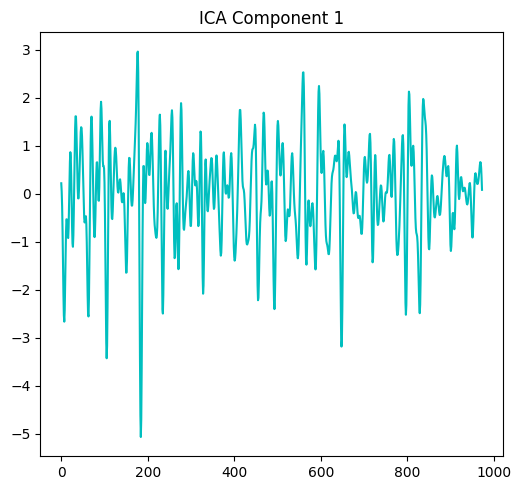

In [47]:
from sklearn.decomposition import FastICA

# X = df_normalized_ratios.values
# X = np.array(list(color_channel_ratios.values()))
X = df1['forehead'].values.reshape(-1, 1)

# Initialize and apply ICA
ica = FastICA(n_components=3, random_state=0)
S_ = ica.fit_transform(X) 
A_ = ica.mixing_ 

# Plot the independent components to identify the one most representative of the heart pulse
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, (component, color) in enumerate(zip(S_.T, ['c', 'm', 'y']), start=1):
    plt.subplot(1, 3, i)
    plt.plot(component, color=color)
    plt.title(f'ICA Component {i}')
plt.tight_layout()
plt.show()


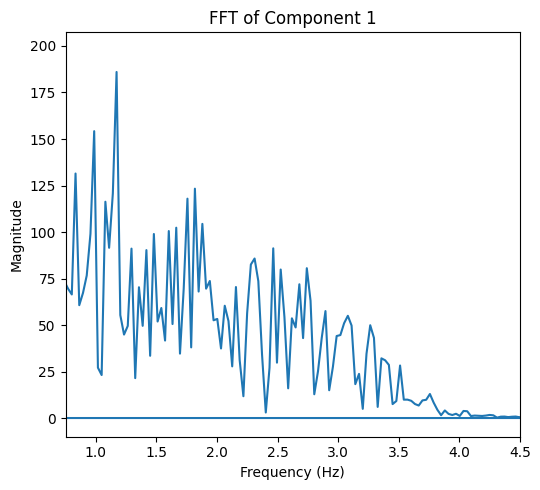

In [48]:
from scipy.fft import fft, fftfreq

fs = 30 
import numpy as np

# Compute the FFT and corresponding frequencies for each component again
fft_components = [fft(component) for component in S_.T]
freqs = fftfreq(X.shape[0], 1/fs)

# Plot the magnitude of the FFT for each component within the heart rate range (0.75 Hz to 4.5 Hz)
plt.figure(figsize=(15, 5))
for i, fft_component in enumerate(fft_components, start=1):
    plt.subplot(1, 3, i)
    plt.plot(freqs, np.abs(fft_component))
    plt.xlim(0.75, 4.5)  # Limit x-axis to target heart rate range
    plt.title(f'FFT of Component {i}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()


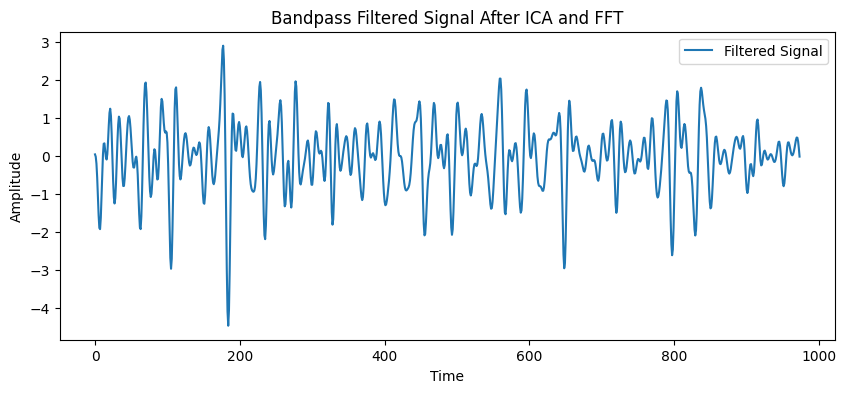

In [49]:
from scipy.signal import butter, filtfilt

# Function to design a bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply a bandpass filter to a signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

most_representative_component = S_[:, 0]  # Second ICA component selected

# Define heart rate range in Hz (45 bpm to 270 bpm)
lowcut = 45 / 60.0
highcut = 270 / 60.0

# Apply bandpass filter to the most representative component
filtered_signal = butter_bandpass_filter(most_representative_component, lowcut, highcut, fs, order=2)

# Plot the filtered signal
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal, label='Filtered Signal')
plt.title('Bandpass Filtered Signal After ICA and FFT')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


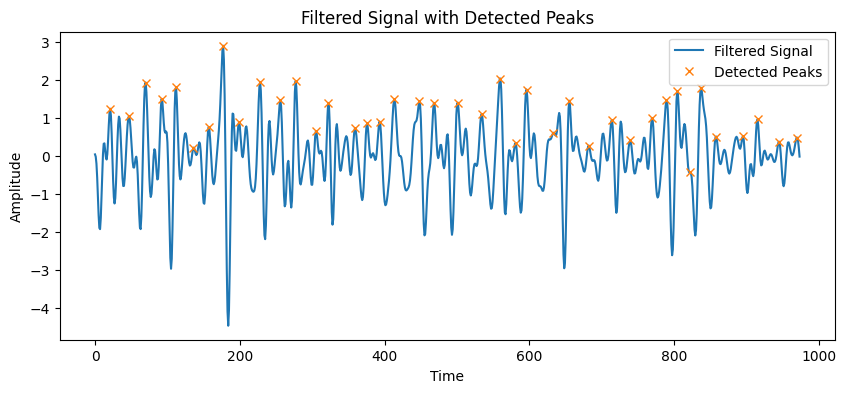

74.0506329113924

In [50]:
from scipy.signal import find_peaks

# Detect peaks in the filtered signal
peaks, _ = find_peaks(filtered_signal, distance=fs*0.5) 

# Calculate IBIs (Interbeat Intervals) in seconds
ibis = np.diff(peaks) / fs

# Calculate the average heart rate
if ibis.size > 0:
    avg_ibi = np.mean(ibis)
    heart_rate = 60 / avg_ibi  # Convert IBIs to heart rate in beats per minute (bpm)
else:
    heart_rate = 0  # No peaks detected, indicating no heart rate could be calculated

# Plot the filtered signal with detected peaks
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal, label='Filtered Signal')
plt.plot(peaks, filtered_signal[peaks], "x", label='Detected Peaks')
plt.title('Filtered Signal with Detected Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

heart_rate

In [51]:
# Convert IBIs to a DataFrame for export
ibi_df = pd.DataFrame(ibis, columns=['IBI'])

# Save the IBI time series to a CSV file
ibi_csv_path = 'ibi_time_series.csv'
ibi_df.to_csv(ibi_csv_path, index=False)

ibi_csv_path

'ibi_time_series.csv'

### Validation based on Supplied BVP data with original UBFC-Phys dataset 

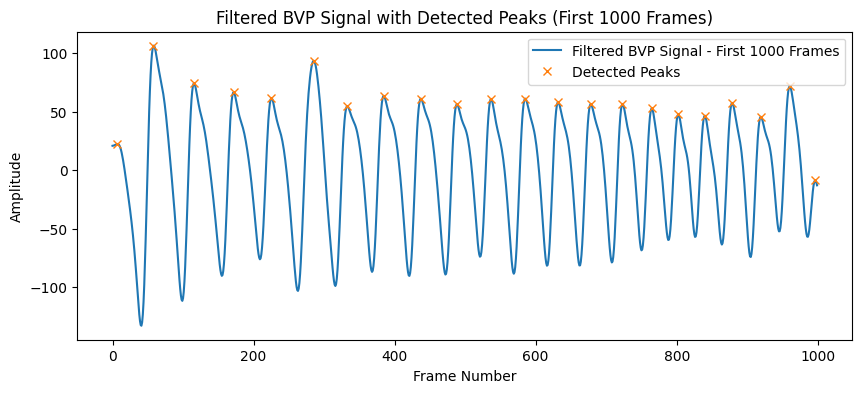

(81.53690596562184, array([0.796875, 0.90625 , 0.875   , 0.828125, 0.9375  ]))

In [52]:
# bvp_path = 'dataset/s2/bvp_s2_T1.csv'
bvp_path = 'bvp_s1_T1.csv'

bvp_df = pd.read_csv(bvp_path)

fs_bvp = 64  # Hz, the sampling rate for BVP signals

# Redo the analysis using the first 1000 frames of the BVP data
filtered_bvp_signal_1000 = butter_bandpass_filter(bvp_df.values.flatten()[:1000], 0.5, 3.5, fs_bvp, order=2)

# Detect peaks in the filtered BVP signal limited to first 1000 frames
peaks_bvp_1000, _ = find_peaks(filtered_bvp_signal_1000, distance=fs_bvp*0.5)

# Calculate IBIs from BVP signal
ibis_bvp_1000 = np.diff(peaks_bvp_1000) / fs_bvp

# Calculate average heart rate from IBIs
if ibis_bvp_1000.size > 0:
    avg_heart_rate_bvp_1000 = 60 / np.mean(ibis_bvp_1000)
else:
    avg_heart_rate_bvp_1000 = 0  # No IBIs

# Plot the filtered BVP signal with detected peaks for visualization
plt.figure(figsize=(10, 4))
plt.plot(filtered_bvp_signal_1000, label='Filtered BVP Signal - First 1000 Frames')
plt.plot(peaks_bvp_1000, filtered_bvp_signal_1000[peaks_bvp_1000], "x", label='Detected Peaks')
plt.title('Filtered BVP Signal with Detected Peaks (First 1000 Frames)')
plt.xlabel('Frame Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

avg_heart_rate_bvp_1000, ibis_bvp_1000[:5]  # Show the average heart rate and the first few IBIs for reference


In [53]:
import numpy as np
from scipy.signal import butter, filtfilt, detrend, find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import zscore

class HeartMetricsCalculator:
    def __init__(self, fs=30):
        self.fs = fs

    @staticmethod
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    @staticmethod
    def compute_IBI(peaks, fs):
        return np.diff(peaks) / fs

    @staticmethod
    def calculate_baevsky_stress_index(ibi):
        hist, bin_edges = np.histogram(ibi, bins=np.arange(0, max(ibi) + 0.05, 0.05))
        amplitude = np.max(hist) / len(ibi)
        sdnn = np.std(ibi)
        bsi = amplitude / (2 * 3.92 * sdnn) * 10
        return bsi

    def calculate_hrv_metrics(self, ibi):
        sdnn = np.std(ibi)
        rmssd = np.sqrt(np.mean(np.square(np.diff(ibi))))
        bsi = self.calculate_baevsky_stress_index(ibi)
        frequencies = fftfreq(len(ibi), d=np.mean(ibi) if len(ibi) > 0 else 0)
        power_spectrum = np.abs(fft(ibi))**2
        lf_band = (0.04, 0.15)
        hf_band = (0.15, 0.4)
        lf_power = np.sum(power_spectrum[(frequencies >= lf_band[0]) & (frequencies < lf_band[1])])
        hf_power = np.sum(power_spectrum[(frequencies >= hf_band[0]) & (frequencies < hf_band[1])])
        lf_hf_ratio = lf_power / hf_power if hf_power != 0 else np.nan
        return sdnn, rmssd, bsi, lf_hf_ratio


### HRV Metrics Comparison

In [54]:
# Initialize calculators for both datasets
fs_current = 30
calculator_current = HeartMetricsCalculator(fs=fs_current)
fs_bvp = 64
calculator_bvp = HeartMetricsCalculator(fs=fs_bvp)

# Calculate HRV metrics for both datasets
sdnn_current, rmssd_current, bsi_current, lf_hf_ratio_current = calculator_current.calculate_hrv_metrics(ibis)
sdnn_bvp, rmssd_bvp, bsi_bvp, lf_hf_ratio_bvp = calculator_bvp.calculate_hrv_metrics(ibis_bvp_1000)

# Calculate average heart rates from IBIs
avg_heart_rate_current = 60 / np.mean(ibis) if ibis.size > 0 else 0
avg_heart_rate_bvp_1000 = 60 / np.mean(ibis_bvp_1000) if ibis_bvp_1000.size > 0 else 0

# Display the HRV metrics and heart rates for both methods
hrv_metrics_comparison = pd.DataFrame({
    'Metric': ['Heart Rate', 'SDNN', 'RMSSD', 'BSI', 'LF/HF Ratio'],
    'Current Calculation': [avg_heart_rate_current, sdnn_current, rmssd_current, bsi_current, lf_hf_ratio_current],
    'BVP Dataset Calculation': [avg_heart_rate_bvp_1000, sdnn_bvp, rmssd_bvp, bsi_bvp, lf_hf_ratio_bvp]
})

print(hrv_metrics_comparison)

        Metric  Current Calculation  BVP Dataset Calculation
0   Heart Rate            74.050633                81.536906
1         SDNN             0.210839                 0.106511
2        RMSSD             0.322454                 0.064707
3          BSI             1.396080                 2.851292
4  LF/HF Ratio             0.606460                 6.962535


In [55]:
from datetime import datetime

current_metrics = hrv_metrics_comparison[['Metric', 'Current Calculation']].copy()
current_metrics['Timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# print(current_metrics)
current_metrics.rename(columns={'Current Calculation': 'Calculation'}, inplace=True)
# Generate a new filename each time
filename = f"hrv_metrics_{np.random.randint(1000)}.csv"


# Save the DataFrame as CSV
current_metrics.to_csv(filename, index=False)
current_metrics

,Metric,Calculation,Timestamp
0,Heart Rate,74.050633,2024-06-11 20:34:54
1,SDNN,0.210839,2024-06-11 20:34:54
2,RMSSD,0.322454,2024-06-11 20:34:54
3,BSI,1.396080,2024-06-11 20:34:54
4,LF/HF Ratio,0.606460,2024-06-11 20:34:54


In [56]:
current_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Metric       5 non-null      object 
 1   Calculation  5 non-null      float64
 2   Timestamp    5 non-null      object 
dtypes: float64(1), object(2)
memory usage: 248.0+ bytes


# Statistial analysis

In [57]:
from scipy.stats import ttest_rel, wilcoxon

# Perform paired t-test and Wilcoxon signed-rank test on the metrics
# Wilcoxon test is used as a non-parametric alternative to the paired t-test

# Convert metrics to numpy arrays for statistical testing
previous_metrics = np.array([sdnn_current, rmssd_current, bsi_current, lf_hf_ratio_current])
bvp_metrics = np.array([sdnn_bvp, rmssd_bvp, bsi_bvp, lf_hf_ratio_bvp])

# Paired t-test
t_test_stat, t_test_p = ttest_rel(previous_metrics, bvp_metrics)

# Wilcoxon signed-rank test
wilcoxon_stat, wilcoxon_p = wilcoxon(previous_metrics, bvp_metrics)

t_test_stat, t_test_p, wilcoxon_stat, wilcoxon_p


(-1.203743353148308, 0.3150083729977525, 3.0, 0.625)

In [242]:
# These statistical tests suggest that there are no statistically significant differences between the two sets of HRV metrics at the conventional alpha level of 0.05. The p-values indicate that the observed differences in HRV metrics could likely be due to random variation rather than systematic differences between the methodologies used to calculate them.

In [58]:
# # First, let's load the provided data into a DataFrame to understand its structure
# import pandas as pd

# # Load the data from the uploaded CSV file
# df = pd.read_csv('hrv_metrics_635.csv')

# # Display the first few rows of the dataframe to understand its structure
# df.head()


In [59]:
df = hrv_metrics_comparison.copy()

In [66]:
hrv_metrics_comparison.to_csv('hrv_metrics_comparison_t1.csv')

In [60]:
df

,Metric,Current Calculation,BVP Dataset Calculation
0,Heart Rate,74.050633,81.536906
1,SDNN,0.210839,0.106511
2,RMSSD,0.322454,0.064707
3,BSI,1.396080,2.851292
4,LF/HF Ratio,0.606460,6.962535


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize dictionaries to hold the calculation results for each metric
mae_results = {}
rmse_results = {}
correlation_results = {}

# Iterate over each unique metric in the dataset
for metric in df['Metric'].unique():
    # Filter the dataframe for the current metric
    metric_df = df[df['Metric'] == metric]
    
    # Calculate MAE
    mae = mean_absolute_error(metric_df['Current Calculation'], metric_df['BVP Dataset Calculation'])
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(metric_df['Current Calculation'], metric_df['BVP Dataset Calculation']))
    
    # Calculate correlation coefficient
    correlation = np.corrcoef(metric_df['Current Calculation'], metric_df['BVP Dataset Calculation'])[0, 1]
    
    # Store the results in the dictionaries
    mae_results[metric] = mae
    rmse_results[metric] = rmse
    correlation_results[metric] = correlation

# Convert the results to DataFrames for better visualization
mae_df = pd.DataFrame(list(mae_results.items()), columns=['Metric', 'MAE'])
rmse_df = pd.DataFrame(list(rmse_results.items()), columns=['Metric', 'RMSE'])
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Metric', 'Correlation'])

(mae_df, rmse_df, correlation_df)


(        Metric       MAE
 0   Heart Rate  7.486273
 1         SDNN  0.104329
 2        RMSSD  0.257747
 3          BSI  1.455212
 4  LF/HF Ratio  6.356076,
         Metric      RMSE
 0   Heart Rate  7.486273
 1         SDNN  0.104329
 2        RMSSD  0.257747
 3          BSI  1.455212
 4  LF/HF Ratio  6.356076,
         Metric  Correlation
 0   Heart Rate          NaN
 1         SDNN          NaN
 2        RMSSD          NaN
 3          BSI          NaN
 4  LF/HF Ratio          NaN)

In [62]:
# Calculate the relative error between the current calculation and the BVP dataset calculation
df['Relative Error'] = abs(df['Current Calculation'] - df['BVP Dataset Calculation']) / df['BVP Dataset Calculation']
df['Accuracy'] = 1 - df['Relative Error']
accuracy_by_metric = df.groupby('Metric')['Accuracy'].mean().reset_index()
print(accuracy_by_metric)

        Metric  Accuracy
0          BSI  0.489631
1   Heart Rate  0.908185
2  LF/HF Ratio  0.087103
3        RMSSD -2.983285
4         SDNN  0.020486


In [63]:
df.groupby('Metric')['Accuracy'].mean().reset_index()['Accuracy'].to_csv('Accuracy.csv')

In [64]:
df.groupby('Metric')['Accuracy'].mean().reset_index()['Accuracy']

0    0.489631
1    0.908185
2    0.087103
3   -2.983285
4    0.020486
Name: Accuracy, dtype: float64